# Comparing Training of Quantized and unquantized Model
In this Notebook we compare the Training of different Models.
All Models are Autoencoders, they differ in quantization. 
The 'normal' Model
The 'creator' model
The 'brevitas' model

In [1]:
import os

import torch
from torch import nn, Tensor

# Creator imports
from elasticai.creator.nn import Sequential
from elasticai.creator.nn.fixed_point import Linear, Tanh, BatchNormedLinear
from elasticai.creator.nn.fixed_point.quantization import quantize

from package.dnn.template.dataset.autoencoder import prepare_training
from package.dnn.dnn_handler import Config_ML_Pipeline, DefaultSettings_MLPipe
from package.yaml_handler import yaml_config_handler
from package.dnn.pytorch_dataclass import (Config_Dataset, DefaultSettingsDataset)
from package.dnn.pytorch_handler import __model_settings_common
import matplotlib.pyplot as plt
from package.plot.plot_dnn import results_training

2024-12-03 09:39:23.438113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733215163.536647   11014 cuda_dnn.cc:8321] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733215163.564142   11014 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 09:39:23.847467: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from package.dnn.pytorch_dataclass import DefaultSettingsTrainMSE

yaml_handler = yaml_config_handler(DefaultSettings_MLPipe, 'config', 'Config_DNN')
dnn_handler = yaml_handler.get_class(Config_ML_Pipeline)
yaml_name_index='Config_AE'


yaml_data = yaml_config_handler(DefaultSettingsDataset, dnn_handler.get_path2config, f'{yaml_name_index}_Dataset')
config_data = yaml_data.get_class(Config_Dataset)

... read YAML file: /home/silas/PycharmProjects/denspp.offline/3_Python/config/Config_DNN.yaml
... read YAML file: /home/silas/PycharmProjects/denspp.offline/3_Python/config/Config_AE_Dataset.yaml


In [3]:
# --- Get Dataset
dataset = prepare_training(settings=config_data, do_classification=False,
                            mode_train_ae=dnn_handler.autoencoder_mode, noise_std=dnn_handler.autoencoder_noise_std,
                            add_noise_cluster=False,
                            use_median_for_mean=True)

... loading and processing the dataset
... do data normalization
... for training are 15894 frames with each 32 points available
... used data points for training: in total 6 classes with 15894 samples
	class 0 (Neuron #0) --> 1393 samples
	class 1 (Neuron #1) --> 1696 samples
	class 2 (Neuron #2) --> 4251 samples
	class 3 (Neuron #3) --> 3427 samples
	class 4 (Neuron #4) --> 2083 samples
	class 5 (Neuron #5) --> 3044 samples


In [4]:
datapoint = dataset.__getitem__(4)
print(datapoint)

{'in': array([ 0.20895523,  0.17910448,  0.13432837,  0.08955224,  0.01492537,
       -0.11940298, -0.13432837,  0.37313432,  1.        ,  0.7164179 ,
       -0.17910448, -0.70149255, -0.6865672 , -0.53731346, -0.41791046,
       -0.3283582 , -0.26865673, -0.23880596, -0.2238806 , -0.20895523,
       -0.19402985, -0.14925373, -0.11940298, -0.08955224, -0.05970149,
       -0.01492537,  0.01492537,  0.01492537,  0.01492537,  0.01492537,
        0.02985075,  0.02985075], dtype=float32), 'out': array([ 0.20895523,  0.17910448,  0.13432837,  0.08955224,  0.01492537,
       -0.11940298, -0.13432837,  0.37313432,  1.        ,  0.7164179 ,
       -0.17910448, -0.70149255, -0.6865672 , -0.53731346, -0.41791046,
       -0.3283582 , -0.26865673, -0.23880596, -0.2238806 , -0.20895523,
       -0.19402985, -0.14925373, -0.11940298, -0.08955224, -0.05970149,
       -0.01492537,  0.01492537,  0.01492537,  0.01492537,  0.01492537,
        0.02985075,  0.02985075], dtype=float32), 'class': 0, 'mean': ar

## Comparing normal/quantized Model

In [5]:
from package.dnn.pytorch_handler import ModelRegistry

models_available = ModelRegistry()

### Quantized Creator Model

#### Quantized Model Hyperparameter

In [6]:
total_bits = 12
frac_bits = 8
bn_affine = True
num_steps = 32

In [7]:
@models_available.register
class dnn_ae_v1_Q(__model_settings_common):
    """Class of an autoencoder with Dense-Layer for feature extraction"""
    def __init__(self, input_size=32, output_size=3):
        super().__init__('Autoencoder')
        self.model_shape = (1, input_size)
        self.model_embedded = False
        iohiddenlayer = [input_size, 20, 14, output_size]
        do_train_bias = True
        do_train_batch = True

        # --- Encoder Path
        self.encoder = Sequential(
            BatchNormedLinear(in_features=iohiddenlayer[0], out_features=iohiddenlayer[1], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits, bn_affine=bn_affine),
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps),
            BatchNormedLinear(in_features=iohiddenlayer[1], out_features=iohiddenlayer[2], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits, bn_affine=bn_affine),
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps),
            BatchNormedLinear(in_features=iohiddenlayer[2], out_features=iohiddenlayer[3], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits, bn_affine=bn_affine),
        )
        # --- Decoder Path
        self.decoder = Sequential(
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps),
            BatchNormedLinear(in_features=iohiddenlayer[3], out_features=iohiddenlayer[2], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits, bn_affine=bn_affine),
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps),
            BatchNormedLinear(in_features=iohiddenlayer[2], out_features=iohiddenlayer[1], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits, bn_affine=bn_affine),
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps),
            BatchNormedLinear(in_features=iohiddenlayer[1], out_features=iohiddenlayer[0], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits, bn_affine=bn_affine),
        )

    def forward(self, x: Tensor) -> [Tensor, Tensor]:
        encoded = self.encoder(x)
        return encoded, self.decoder(encoded)

    def create_encoder_design(self, name):
        return self.encoder.create_design(name)

### Normal Autoencoder

In [8]:
@models_available.register
class dnn_ae_v1(__model_settings_common):
    """Class of an autoencoder with Dense-Layer for feature extraction"""
    def __init__(self, input_size=32, output_size=3):
        super().__init__('Autoencoder')
        self.model_shape = (1, input_size)
        self.model_embedded = False
        iohiddenlayer = [input_size, 20, 14, output_size]
        do_train_bias = True
        do_train_batch = True

        # --- Encoder Path
        self.encoder = nn.Sequential(
            nn.Linear(in_features=iohiddenlayer[0], out_features=iohiddenlayer[1], bias=do_train_bias),
            nn.BatchNorm1d(iohiddenlayer[1], affine=True),
            nn.Tanh(),
            nn.Linear(in_features=iohiddenlayer[1], out_features=iohiddenlayer[2], bias=do_train_bias),
            nn.BatchNorm1d(iohiddenlayer[2], affine=True),
            nn.Tanh(),
            nn.Linear(in_features=iohiddenlayer[2], out_features=iohiddenlayer[3], bias=do_train_bias),
        )
        # --- Decoder Path
        self.decoder = nn.Sequential(
            nn.Tanh(),
            nn.Linear(in_features=iohiddenlayer[3], out_features=iohiddenlayer[2], bias=do_train_bias),
            nn.BatchNorm1d(iohiddenlayer[2], affine=True),
            nn.Tanh(),
            nn.Linear(in_features=iohiddenlayer[2], out_features=iohiddenlayer[1], bias=do_train_bias),
            nn.BatchNorm1d(iohiddenlayer[1], affine=True),
            nn.Tanh(),
            nn.Linear(in_features=iohiddenlayer[1], out_features=iohiddenlayer[0], bias=do_train_bias),
        )

    def forward(self, x: Tensor) -> [Tensor, Tensor]:
        encoded = self.encoder(x)
        return encoded, self.decoder(encoded)

### Creator Model without BatchNorm

In [9]:
@models_available.register
class dnn_ae_v1_Q_wo_BN(__model_settings_common):
    """Class of an autoencoder with Dense-Layer for feature extraction"""
    def __init__(self, input_size=32, output_size=3):
        super().__init__('Autoencoder')
        self.model_shape = (1, input_size)
        self.model_embedded = False
        iohiddenlayer = [input_size, 20, 14, output_size]
        do_train_bias = True
        do_train_batch = True

        # --- Encoder Path
        self.encoder = Sequential(
            Linear(in_features=iohiddenlayer[0], out_features=iohiddenlayer[1], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits),
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps),
            Linear(in_features=iohiddenlayer[1], out_features=iohiddenlayer[2], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits),
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps),
            Linear(in_features=iohiddenlayer[2], out_features=iohiddenlayer[3], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits),
        )
        # --- Decoder Path
        self.decoder = Sequential(
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps),
            Linear(in_features=iohiddenlayer[3], out_features=iohiddenlayer[2], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits),
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps),
            Linear(in_features=iohiddenlayer[2], out_features=iohiddenlayer[1], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits),
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps),
            Linear(in_features=iohiddenlayer[1], out_features=iohiddenlayer[0], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits),
        )

    def forward(self, x: Tensor) -> [Tensor, Tensor]:
        encoded = self.encoder(x)
        return encoded, self.decoder(encoded)
    
    def forward_first_layer(self, x: Tensor) -> Tensor:
        return self.encoder[0](x)
    
    def create_design(self, name):
        encoder = self.encoder.create_design(f"{name}_encoder")
        decoder = self.decoder.create_design(f"{name}_decoder")
        return encoder, decoder
        

### Normal Model without BatchNorm

In [10]:
@models_available.register
class dnn_ae_v1_wo_bn(__model_settings_common):
    """Class of an autoencoder with Dense-Layer for feature extraction"""
    def __init__(self, input_size=32, output_size=3):
        super().__init__('Autoencoder')
        self.model_shape = (1, input_size)
        self.model_embedded = False
        iohiddenlayer = [input_size, 20, 14, output_size]
        do_train_bias = True
        do_train_batch = True

        # --- Encoder Path
        self.encoder = nn.Sequential(
            nn.Linear(in_features=iohiddenlayer[0], out_features=iohiddenlayer[1], bias=do_train_bias),
            #nn.BatchNorm1d(iohiddenlayer[1], affine=True),
            nn.Tanh(),
            nn.Linear(in_features=iohiddenlayer[1], out_features=iohiddenlayer[2], bias=do_train_bias),
            #nn.BatchNorm1d(iohiddenlayer[2], affine=True),
            nn.Tanh(),
            nn.Linear(in_features=iohiddenlayer[2], out_features=iohiddenlayer[3], bias=do_train_bias),
        )
        # --- Decoder Path
        self.decoder = nn.Sequential(
            nn.Tanh(),
            nn.Linear(in_features=iohiddenlayer[3], out_features=iohiddenlayer[2], bias=do_train_bias),
            #nn.BatchNorm1d(iohiddenlayer[2], affine=True),
            nn.Tanh(),
            nn.Linear(in_features=iohiddenlayer[2], out_features=iohiddenlayer[1], bias=do_train_bias),
            #nn.BatchNorm1d(iohiddenlayer[1], affine=True),
            nn.Tanh(),
            nn.Linear(in_features=iohiddenlayer[1], out_features=iohiddenlayer[0], bias=do_train_bias),
        )

    def forward(self, x: Tensor) -> [Tensor, Tensor]:
        encoded = self.encoder(x)
        return encoded, self.decoder(encoded)

### Training

In [11]:
from package.dnn.pytorch_dataclass import Config_PyTorch

default_train = DefaultSettingsTrainMSE
default_train.model_name = dnn_ae_v1.__name__
yaml_nn = yaml_config_handler(default_train, dnn_handler.get_path2config, f'{yaml_name_index}_Training')
config_train = yaml_nn.get_class(Config_PyTorch)

dnn_handler.do_plot  = False

... read YAML file: /home/silas/PycharmProjects/denspp.offline/3_Python/config/Config_AE_Training.yaml


In [12]:
from datetime import datetime, date
from package.dnn.pytorch_pipeline import do_train_autoencoder

q_model = models_available.build_model('dnn_ae_v1_Q')
model = models_available.build_model('dnn_ae_v1')
q_model_wo_bn = models_available.build_model('dnn_ae_v1_Q_wo_BN')
model_wo_bn = models_available.build_model('dnn_ae_v1_wo_bn')
path4vhdl = f'vhdl/run_{date.today()}_{datetime.utcnow().strftime("%H%M")}'

q_model_stats = dict()
model_stats = dict()
q_model_wo_bn_stats = dict()
model_wo_bn_stats = dict()

{'model': <class 'torch.nn.modules.container.Sequential'>}
{'model': <class 'torch.nn.modules.container.Sequential'>}
{'model': <class 'torch.nn.modules.container.Sequential'>}
{'model': <class 'torch.nn.modules.container.Sequential'>}


In [13]:
'''
q_model_stats['metrics'], q_model_stats['data_result'], q_model_stats['path2folder'] = do_train_autoencoder( #metrics, data_result, path2folder
        config_ml=dnn_handler, config_data=config_data, config_train=config_train,
        used_dataset=dataset, used_model=q_model, calc_custom_metrics=['snr'], save_vhdl=False, path4vhdl=path4vhdl
    )
'''

"\nq_model_stats['metrics'], q_model_stats['data_result'], q_model_stats['path2folder'] = do_train_autoencoder( #metrics, data_result, path2folder\n        config_ml=dnn_handler, config_data=config_data, config_train=config_train,\n        used_dataset=dataset, used_model=q_model, calc_custom_metrics=['snr'], save_vhdl=False, path4vhdl=path4vhdl\n    )\n"

In [14]:
'''
model_stats['metrics'], model_stats['data_result'], model_stats['path2folder'] = do_train_autoencoder( #metrics, data_result, path2folder
        config_ml=dnn_handler, config_data=config_data, config_train=config_train,
        used_dataset=dataset, used_model=model, calc_custom_metrics=['snr'], save_vhdl=False, path4vhdl=path4vhdl
    )
'''

"\nmodel_stats['metrics'], model_stats['data_result'], model_stats['path2folder'] = do_train_autoencoder( #metrics, data_result, path2folder\n        config_ml=dnn_handler, config_data=config_data, config_train=config_train,\n        used_dataset=dataset, used_model=model, calc_custom_metrics=['snr'], save_vhdl=False, path4vhdl=path4vhdl\n    )\n"

In [15]:
q_model_wo_bn_stats['metrics'], q_model_wo_bn_stats['data_result'], q_model_wo_bn_stats['path2folder'] = do_train_autoencoder( #metrics, data_result, path2folder
        config_ml=dnn_handler, config_data=config_data, config_train=config_train,
        used_dataset=dataset, used_model=q_model_wo_bn, calc_custom_metrics=['snr'], save_vhdl=True, path4vhdl=path4vhdl, print_model=False
    )


Using PyTorch with Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz (@ 3.403 GHz) on Linux

Training starts on 09:39:34


/home/silas/PycharmProjects/denspp.offline/3_Python/package/dnn/pytorch/autoencoder.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(load(pat

... results of epoch 1/15 [6.67 %]: train_loss = 0.16333,	valid_loss = 0.09958,	delta_loss = 0.063753
... results of epoch 2/15 [13.33 %]: train_loss = 0.06440,	valid_loss = 0.03824,	delta_loss = 0.026165
... results of epoch 3/15 [20.00 %]: train_loss = 0.03248,	valid_loss = 0.02728,	delta_loss = 0.005199
... results of epoch 4/15 [26.67 %]: train_loss = 0.02361,	valid_loss = 0.02025,	delta_loss = 0.003355
... results of epoch 5/15 [33.33 %]: train_loss = 0.01836,	valid_loss = 0.01653,	delta_loss = 0.001829
... results of epoch 6/15 [40.00 %]: train_loss = 0.01610,	valid_loss = 0.01679,	delta_loss = -0.000686
... results of epoch 7/15 [46.67 %]: train_loss = 0.01559,	valid_loss = 0.01541,	delta_loss = 0.000177
... results of epoch 8/15 [53.33 %]: train_loss = 0.01456,	valid_loss = 0.01404,	delta_loss = 0.000516
... results of epoch 9/15 [60.00 %]: train_loss = 0.01359,	valid_loss = 0.01356,	delta_loss = 0.000032
... results of epoch 10/15 [66.67 %]: train_loss = 0.01244,	valid_loss = 

/home/silas/PycharmProjects/denspp.offline/3_Python/package/dnn/pytorch/autoencoder.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test = load(path2model)


... preparing results for plot generation
... saving results: /home/silas/PycharmProjects/denspp.offline/3_Python/runs/20241203_093934_train_dnn_ae_v1_Q_wo_BN_ae/results_ae.npy
 Saving Hardware Design


In [16]:
model_wo_bn_stats['metrics'], model_wo_bn_stats['data_result'], model_wo_bn_stats['path2folder'] = do_train_autoencoder( #metrics, data_result, path2folder
        config_ml=dnn_handler, config_data=config_data, config_train=config_train,
        used_dataset=dataset, used_model=model_wo_bn, calc_custom_metrics=['snr'], save_vhdl=False, path4vhdl=path4vhdl, print_model=False
    )


Using PyTorch with Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz (@ 3.601 GHz) on Linux

Training starts on 09:39:57
... results of epoch 1/15 [6.67 %]: train_loss = 0.15175,	valid_loss = 0.08362,	delta_loss = 0.068128
... results of epoch 2/15 [13.33 %]: train_loss = 0.05287,	valid_loss = 0.03304,	delta_loss = 0.019834
... results of epoch 3/15 [20.00 %]: train_loss = 0.02550,	valid_loss = 0.01885,	delta_loss = 0.006647
... results of epoch 4/15 [26.67 %]: train_loss = 0.01566,	valid_loss = 0.01292,	delta_loss = 0.002730
... results of epoch 5/15 [33.33 %]: train_loss = 0.01230,	valid_loss = 0.01154,	delta_loss = 0.000759
... results of epoch 6/15 [40.00 %]: train_loss = 0.01147,	valid_loss = 0.01112,	delta_loss = 0.000354
... results of epoch 7/15 [46.67 %]: train_loss = 0.01111,	valid_loss = 0.01084,	delta_loss = 0.000271
... results of epoch 8/15 [53.33 %]: train_loss = 0.01083,	valid_loss = 0.01057,	delta_loss = 0.000258
... results of epoch 9/15 [60.00 %]: train_loss = 0.01056,	valid

## Plotting Results

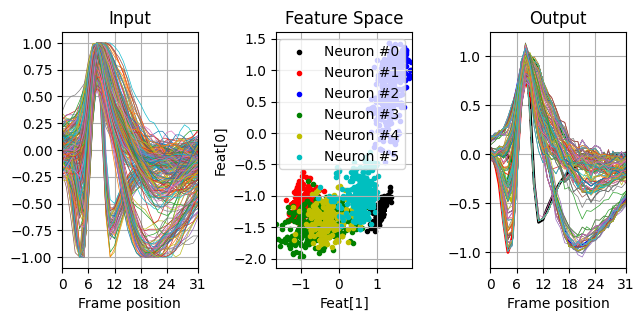

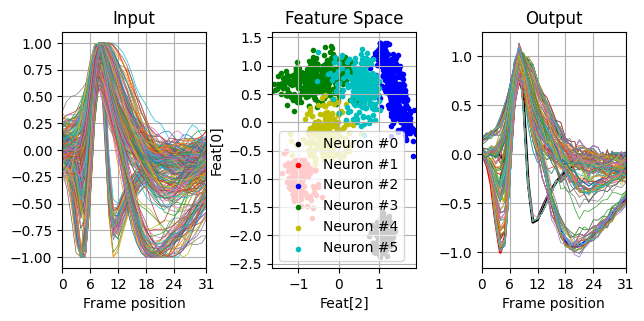

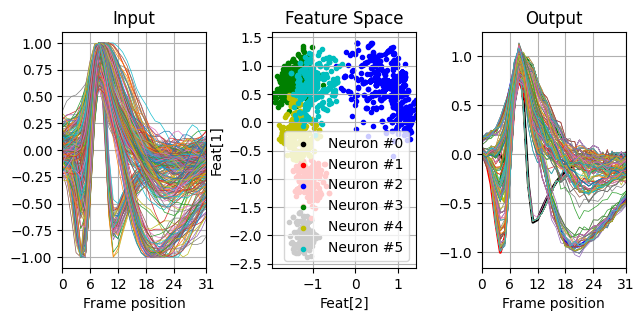

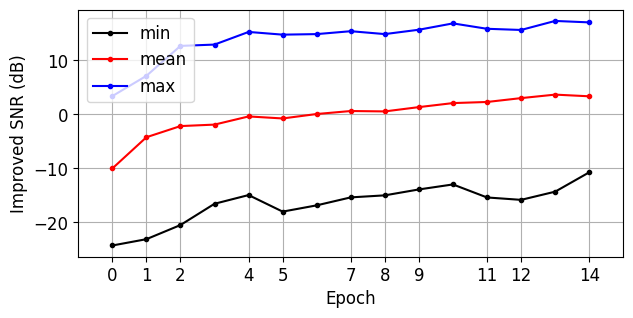

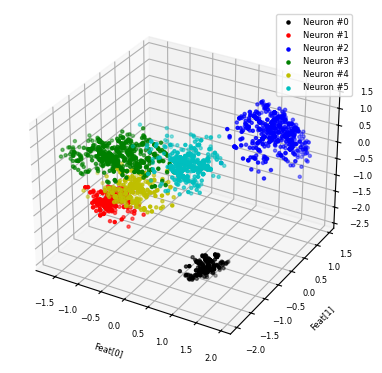

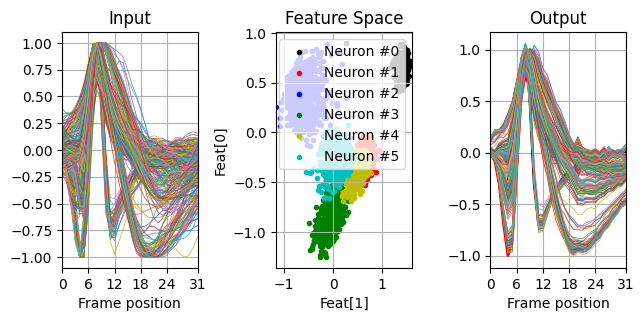

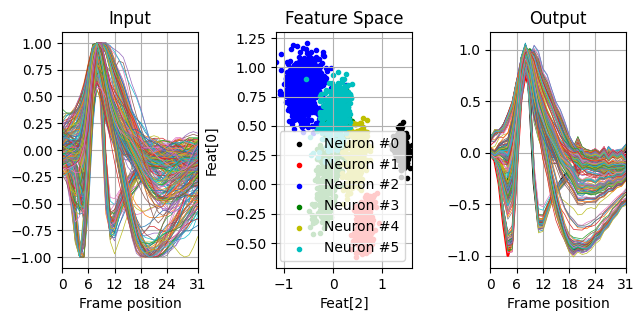

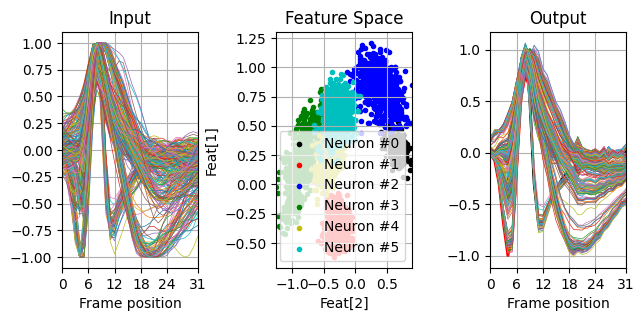

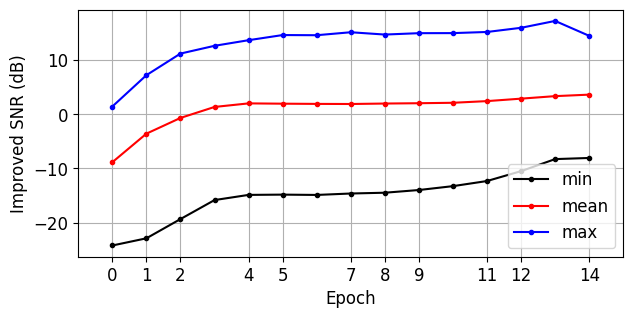

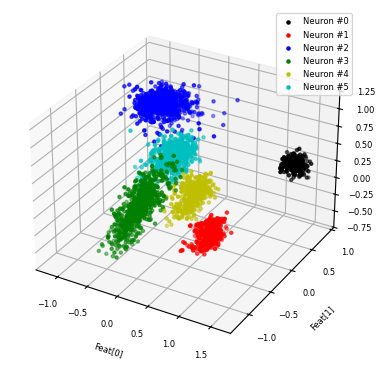

In [17]:
used_first_fold = [key for key in q_model_wo_bn_stats["metrics"].keys()][0]
results_training(
    path=q_model_wo_bn_stats["path2folder"], cl_dict=q_model_wo_bn_stats["data_result"]['cl_dict'], feat=q_model_wo_bn_stats["data_result"]['feat'],
    yin=q_model_wo_bn_stats["data_result"]['input'], ypred=q_model_wo_bn_stats["data_result"]['pred'], ymean=dataset.get_mean_waveforms,
    yclus=q_model_wo_bn_stats["data_result"]['valid_clus'], snr=q_model_wo_bn_stats["metrics"][used_first_fold]['snr'],
    show_plot=dnn_handler.do_block
)
used_first_fold = [key for key in model_wo_bn_stats["metrics"].keys()][0]
results_training(
    path=model_wo_bn_stats["path2folder"], cl_dict=model_wo_bn_stats["data_result"]['cl_dict'], feat=model_wo_bn_stats["data_result"]['feat'],
    yin=model_wo_bn_stats["data_result"]['input'], ypred=model_wo_bn_stats["data_result"]['pred'], ymean=dataset.get_mean_waveforms,
    yclus=model_wo_bn_stats["data_result"]['valid_clus'], snr=model_wo_bn_stats["metrics"][used_first_fold]['snr'],
    show_plot=dnn_handler.do_block
)

### Model Comparison

#### Comparing Model without BatchNorm and Quantized Model without BatchNorm

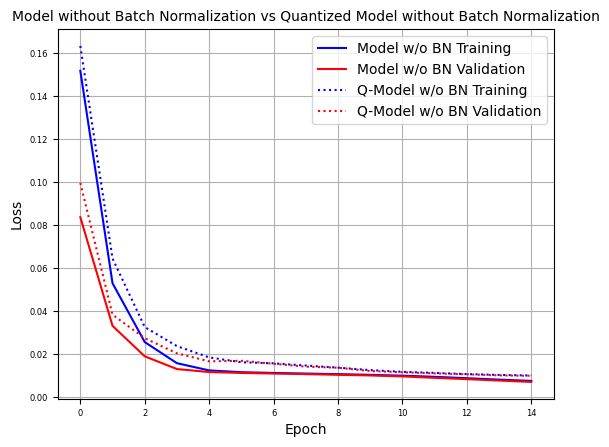

In [18]:
fig, ax = plt.subplots()

model_loss_train = model_wo_bn_stats['metrics']['fold_000']['loss_train']
model_loss_valid = model_wo_bn_stats['metrics']['fold_000']['loss_valid']

q_model_wo_bn_loss_train = q_model_wo_bn_stats['metrics']['fold_000']['loss_train']
q_model_wo_bn_loss_valid = q_model_wo_bn_stats['metrics']['fold_000']['loss_valid']

ax.plot(model_loss_train, label='Model w/o BN Training', linestyle='solid', color='blue')
ax.plot(model_loss_valid, label='Model w/o BN Validation', linestyle='solid', color='red')
ax.plot(q_model_wo_bn_loss_train, label='Q-Model w/o BN Training', linestyle='dotted', color='blue')
ax.plot(q_model_wo_bn_loss_valid, label='Q-Model w/o BN Validation', linestyle='dotted', color='red')

font = {'size'   : 10}

ax.grid()
ax.legend(fontsize=font['size'])
ax.set_xlabel('Epoch', fontdict=font)
ax.set_ylabel('Loss', fontdict=font)
ax.set_title(label='Model without Batch Normalization vs Quantized Model without Batch Normalization', fontdict=font)

# Save Plot in runs Folder
index_folder = 'compare'
model_names = model_wo_bn.get_modelname + 'VS' + q_model_wo_bn.get_modelname
folder_name = f'runs/comparisons/{datetime.now().strftime("%Y%m%d_%H%M%S")}_{index_folder}_{model_names}'
os.makedirs(folder_name, exist_ok=True)
fig.savefig(f'{folder_name}/train_valid_loss.svg', format='svg')

## Testing Inference

In [20]:
datapoint['in']

array([ 0.20895523,  0.17910448,  0.13432837,  0.08955224,  0.01492537,
       -0.11940298, -0.13432837,  0.37313432,  1.        ,  0.7164179 ,
       -0.17910448, -0.70149255, -0.6865672 , -0.53731346, -0.41791046,
       -0.3283582 , -0.26865673, -0.23880596, -0.2238806 , -0.20895523,
       -0.19402985, -0.14925373, -0.11940298, -0.08955224, -0.05970149,
       -0.01492537,  0.01492537,  0.01492537,  0.01492537,  0.01492537,
        0.02985075,  0.02985075], dtype=float32)

In [22]:
input = torch.Tensor(datapoint['in'])
q_input = quantize(input, total_bits=total_bits, frac_bits=frac_bits)
print(f"Quantized Input = {q_input}")
output = q_model_wo_bn(q_input)
print(f"Output = {output[0]}")

Quantized Input = tensor([ 0.2070,  0.1758,  0.1328,  0.0859,  0.0117, -0.1172, -0.1328,  0.3711,
         1.0000,  0.7148, -0.1758, -0.6992, -0.6836, -0.5352, -0.4141, -0.3281,
        -0.2656, -0.2383, -0.2227, -0.2070, -0.1914, -0.1484, -0.1172, -0.0859,
        -0.0586, -0.0117,  0.0117,  0.0117,  0.0117,  0.0117,  0.0273,  0.0273])
Output = tensor([ 1.1250, -1.1523, -2.0273], grad_fn=<ClampBackward1>)


In [24]:
from fxpmath import Fxp
'''
for i in q_input[0]:
    val = Fxp(float(i), signed=False, n_word=12, n_frac=8)
    print(val.bin())
'''
    
def value_to_binary(x : Tensor) -> str:
    val = Fxp(float(x), signed=True, n_word=total_bits, n_frac=frac_bits)
    return val.bin()
    
def tensor_to_vhdl_vector(X : Tensor) -> str:
    std_logic_vector : str = "("
    for idx, val in enumerate(X):
        std_logic_vector += "\""
        std_logic_vector += value_to_binary(val)
        std_logic_vector += "\","
    std_logic_vector = std_logic_vector[:-1]
    std_logic_vector += ")"
    return std_logic_vector

print(f"Input={tensor_to_vhdl_vector(q_input)}")
print(f"Output={tensor_to_vhdl_vector(output[0])}={output[0]}")

Input=("000000110101","000000101101","000000100010","000000010110","000000000011","111111100010","111111011110","000001011111","000100000000","000010110111","111111010011","111101001101","111101010001","111101110111","111110010110","111110101100","111110111100","111111000011","111111000111","111111001011","111111001111","111111011010","111111100010","111111101010","111111110001","111111111101","000000000011","000000000011","000000000011","000000000011","000000000111","000000000111")
Output=("000100100000","111011011001","110111111001")=tensor([ 1.1250, -1.1523, -2.0273], grad_fn=<ClampBackward1>)


### Just first layer

In [26]:
input_layer_0 = input
q_input_layer_0 = quantize(input_layer_0, total_bits=total_bits, frac_bits=frac_bits)
print(f"Quantized Input = {q_input_layer_0}")
output_layer_0 = q_model_wo_bn.forward_first_layer(q_input_layer_0)
print(f"Output = {output_layer_0}")

Quantized Input = tensor([ 0.2070,  0.1758,  0.1328,  0.0859,  0.0117, -0.1172, -0.1328,  0.3711,
         1.0000,  0.7148, -0.1758, -0.6992, -0.6836, -0.5352, -0.4141, -0.3281,
        -0.2656, -0.2383, -0.2227, -0.2070, -0.1914, -0.1484, -0.1172, -0.0859,
        -0.0586, -0.0117,  0.0117,  0.0117,  0.0117,  0.0117,  0.0273,  0.0273])
Output = tensor([-0.9805,  0.6914,  0.1562,  0.5039,  0.3242, -0.9805, -0.4609,  0.0820,
         0.8203,  0.0508, -0.2969, -0.9805, -0.5781, -0.1094,  0.8867, -0.0508,
         0.4102, -0.7734,  0.7539,  0.1914], grad_fn=<ClampBackward1>)


In [27]:
print(f"Input={tensor_to_vhdl_vector(q_input_layer_0)}")
print(f"Output={tensor_to_vhdl_vector(output_layer_0)}")

Input=("000000110101","000000101101","000000100010","000000010110","000000000011","111111100010","111111011110","000001011111","000100000000","000010110111","111111010011","111101001101","111101010001","111101110111","111110010110","111110101100","111110111100","111111000011","111111000111","111111001011","111111001111","111111011010","111111100010","111111101010","111111110001","111111111101","000000000011","000000000011","000000000011","000000000011","000000000111","000000000111")
Output=("111100000101","000010110001","000000101000","000010000001","000001010011","111100000101","111110001010","000000010101","000011010010","000000001101","111110110100","111100000101","111101101100","111111100100","000011100011","111111110011","000001101001","111100111010","000011000001","000000110001")
